In [1]:
import json
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt


In [2]:
NB_DIR = Path().resolve()
ROOT = NB_DIR.parent.parent
# print(ROOT)
DATA_DIR = Path(ROOT / "data/lane_segmentation_new/new")
IMAGE_EXT = ".png"

IMG_SIZE = (720, 960)   # (width, height)
BATCH_SIZE = 1
EPOCHS = 50
LR = 1e-4

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cuda


In [3]:
def polygons_to_mask_labelme(data, w, h):
    """
    data: loaded LabelMe json dict
    w,h: original image width/height
    returns: binary mask (H, W) float32 in original resolution
    """
    mask = np.zeros((h, w), dtype=np.uint8)

    for shape in data["shapes"]:
        if shape.get("shape_type") != "polygon":
            continue
        pts = np.array(shape["points"], dtype=np.int32)  # LabelMe points are in original image coords
        cv2.fillPoly(mask, [pts], 1)

    return mask.astype(np.float32)


In [4]:
class LaneDataset(Dataset):
    def __init__(self, folder, out_size=(720, 960)):
        self.folder = Path(folder)
        self.images = sorted(self.folder.glob(f"*{IMAGE_EXT}"))
        self.out_w, self.out_h = out_size  # (W,H)

        self.img_tf = T.Compose([
            T.Resize((self.out_h, self.out_w)),  # torchvision wants (H,W)
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        json_path = img_path.with_suffix(".json")

        image = Image.open(img_path).convert("RGB")
        w, h = image.size  # original size

        with open(json_path, "r") as f:
            data = json.load(f)

        mask_np = polygons_to_mask_labelme(data, w, h)  # (H,W) original

        # Resize image
        image_t = self.img_tf(image)

        # Resize mask with nearest neighbor (keep it binary)
        mask_rs = cv2.resize(mask_np, (self.out_w, self.out_h), interpolation=cv2.INTER_NEAREST)
        mask_t = torch.from_numpy(mask_rs).unsqueeze(0).float()

        return image_t, mask_t


C:\Users\jleto\Projects\rev-vision\data\lane_segmentation_new\new
Samples: 97


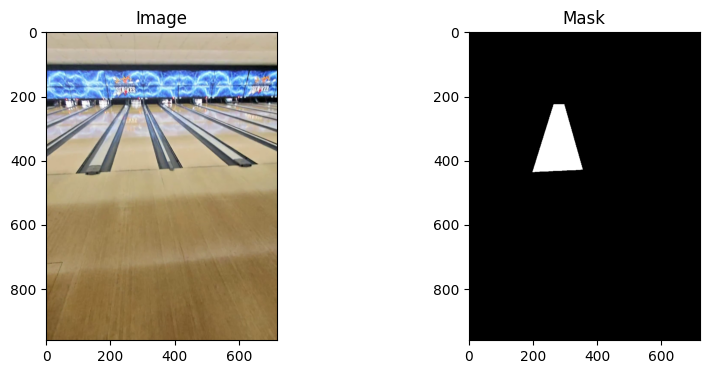

In [10]:
print(DATA_DIR)
dataset = LaneDataset(DATA_DIR)
print("Samples:", len(dataset))

img, mask = dataset[0]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Image")
plt.imshow(img.permute(1,2,0))

plt.subplot(1,2,2)
plt.title("Mask")
plt.imshow(mask[0], cmap="gray")
plt.show()


In [6]:
from torch.utils.data import DataLoader

loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)


In [7]:
def get_deeplab_model():
    weights = DeepLabV3_ResNet50_Weights.DEFAULT
    model = deeplabv3_resnet50(weights=weights, aux_loss=False)

    in_ch = model.classifier[-1].in_channels
    model.classifier[-1] = nn.Conv2d(in_ch, 1, kernel_size=1)

    model.aux_classifier = None  # IMPORTANT

    return model


In [9]:
model = get_deeplab_model().to(DEVICE)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

for p in model.backbone.parameters():
    p.requires_grad = False



ValueError: The parameter 'aux_loss' expected value True but got False instead.

In [ ]:
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0

    for imgs, masks in loader:
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE)

        preds = model(imgs)["out"]
        loss = loss_fn(preds, masks)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss:.4f}")


OutOfMemoryError: CUDA out of memory. Tried to allocate 44.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 9.60 GiB is allocated by PyTorch, and 154.88 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
MODEL_PATH = "lane_deeplab.pth"

torch.save(
    {
        "model_state_dict": model.state_dict(),
        "img_size": (720, 960)
    },
    MODEL_PATH
)

print(f"Model saved to {MODEL_PATH}")
